In [2]:
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [111]:
def wrangle(filepath):

    # Read CSV file
    df = pd.read_csv(filepath)
    
    # Drop a  all column
    df = df.drop(columns=["unix",'symbol','low','open','high','Volume BTC','Volume USD'])


    # Convert date column to datetime format
    df["date"] = pd.to_datetime(df["date"])

    # Set date column as index
    df.set_index("date", inplace=True)

    # Localize timezone
    #df.index = df.index.tz_localize("UTC")

    # Remove outliers
    #df = df[df["P2"] < 500]

    # Resample to 1hr window
    y = df["close"].resample("1H").mean().fillna(method='ffill')

    return y

In [112]:
y=wrangle(r'C:\Users\Nassoh\Desktop\DataSienceMyProject\BTC Price\Data\BTCUSD_hour.csv')
y.shape

(43339,)

# Split

In [113]:
Prediction=y.shape[0]-24
cutoff_test =int(Prediction)
y_train =y.iloc[:cutoff_test]
y_test =y.iloc[cutoff_test:int(cutoff_test+24)]
y_train

date
2018-05-15 06:00:00     8740.99
2018-05-15 07:00:00     8739.00
2018-05-15 08:00:00     8728.49
2018-05-15 09:00:00     8708.32
2018-05-15 10:00:00     8795.90
                         ...   
2023-04-23 20:00:00    27512.00
2023-04-23 21:00:00    27515.00
2023-04-23 22:00:00    27599.00
2023-04-23 23:00:00    27596.00
2023-04-24 00:00:00    27809.00
Freq: H, Name: close, Length: 43315, dtype: float64

In [114]:
y_test

date
2023-04-24 01:00:00    27768.0
2023-04-24 02:00:00    27740.0
2023-04-24 03:00:00    27781.0
2023-04-24 04:00:00    27704.0
2023-04-24 05:00:00    27657.0
2023-04-24 06:00:00    27549.0
2023-04-24 07:00:00    27449.0
2023-04-24 08:00:00    27181.0
2023-04-24 09:00:00    27306.0
2023-04-24 10:00:00    27414.0
2023-04-24 11:00:00    27540.0
2023-04-24 12:00:00    27441.0
2023-04-24 13:00:00    27629.0
2023-04-24 14:00:00    27432.0
2023-04-24 15:00:00    27266.0
2023-04-24 16:00:00    27116.0
2023-04-24 17:00:00    27381.0
2023-04-24 18:00:00    27337.0
2023-04-24 19:00:00    27380.0
2023-04-24 20:00:00    27453.0
2023-04-24 21:00:00    27414.0
2023-04-24 22:00:00    27468.0
2023-04-24 23:00:00    27512.0
2023-04-25 00:00:00    27499.0
Freq: H, Name: close, dtype: float64

# Baseline

In [64]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean BTC Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean BTC Reading: 21326.4
Baseline MAE: 14221.02


# Model

In [65]:
# Create ranges for possible  𝑝 and  𝑞 values
p_params = range(0,25,8)
q_params = range(0,3,1)

In [66]:
print(list(p_params))
print(list(q_params))

[0, 8, 16, 24]
[0, 1, 2]


In [14]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model =ARIMA(y_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred =model.predict()
        # Calculate training MAE
        mae =mean_absolute_error(y_train,y_pred)
        # print mae 
        print("MAE : ",mae)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.72 seconds.
MAE :  14686.098980530043
Trained ARIMA (0, 0, 1) in 9.31 seconds.
MAE :  7394.086004134019
Trained ARIMA (0, 0, 2) in 28.42 seconds.
MAE :  3910.3002892962636
Trained ARIMA (8, 0, 0) in 7.72 seconds.
MAE :  108.04554389484275
Trained ARIMA (8, 0, 1) in 10.33 seconds.
MAE :  108.04601258159315
Trained ARIMA (8, 0, 2) in 85.82 seconds.
MAE :  108.04152418264857
Trained ARIMA (16, 0, 0) in 37.4 seconds.
MAE :  108.08981075668235
Trained ARIMA (16, 0, 1) in 31.94 seconds.
MAE :  108.08504341310935


c:\Users\Nassoh\.conda\envs\new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (16, 0, 2) in 210.97 seconds.
MAE :  108.0833740213356
Trained ARIMA (24, 0, 0) in 123.78 seconds.
MAE :  108.06313620966654
Trained ARIMA (24, 0, 1) in 73.11 seconds.
MAE :  108.05296122119574
Trained ARIMA (24, 0, 2) in 480.68 seconds.
MAE :  108.03406315748315

{0: [14686.098980530043, 7394.086004134019, 3910.3002892962636], 8: [108.04554389484275, 108.04601258159315, 108.04152418264857], 16: [108.08981075668235, 108.08504341310935, 108.0833740213356], 24: [108.06313620966654, 108.05296122119574, 108.03406315748315]}


# Best params
 Trained ARIMA (8, 0, 1) in 10.33 seconds.
 MAE :  108.04601258159315
 p=8 , q=1

In [40]:
mae_df =pd.DataFrame(mae_grid)
mae_df.round(4)

0         8         16        24
0  14686.0990  108.0455  108.0898  108.0631
1   7394.0860  108.0460  108.0850  108.0530
2   3910.3003  108.0415  108.0834  108.0341

In [41]:
sns.heatmap(mae_df)
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('ARMA Grid Search (MAE)')

Text(0.5, 1.0, 'ARMA Grid Search (MAE)')

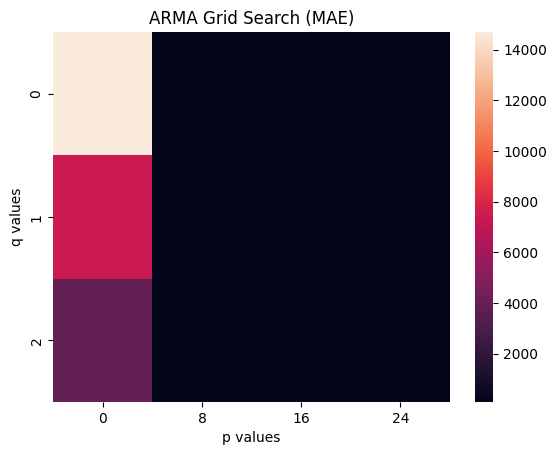

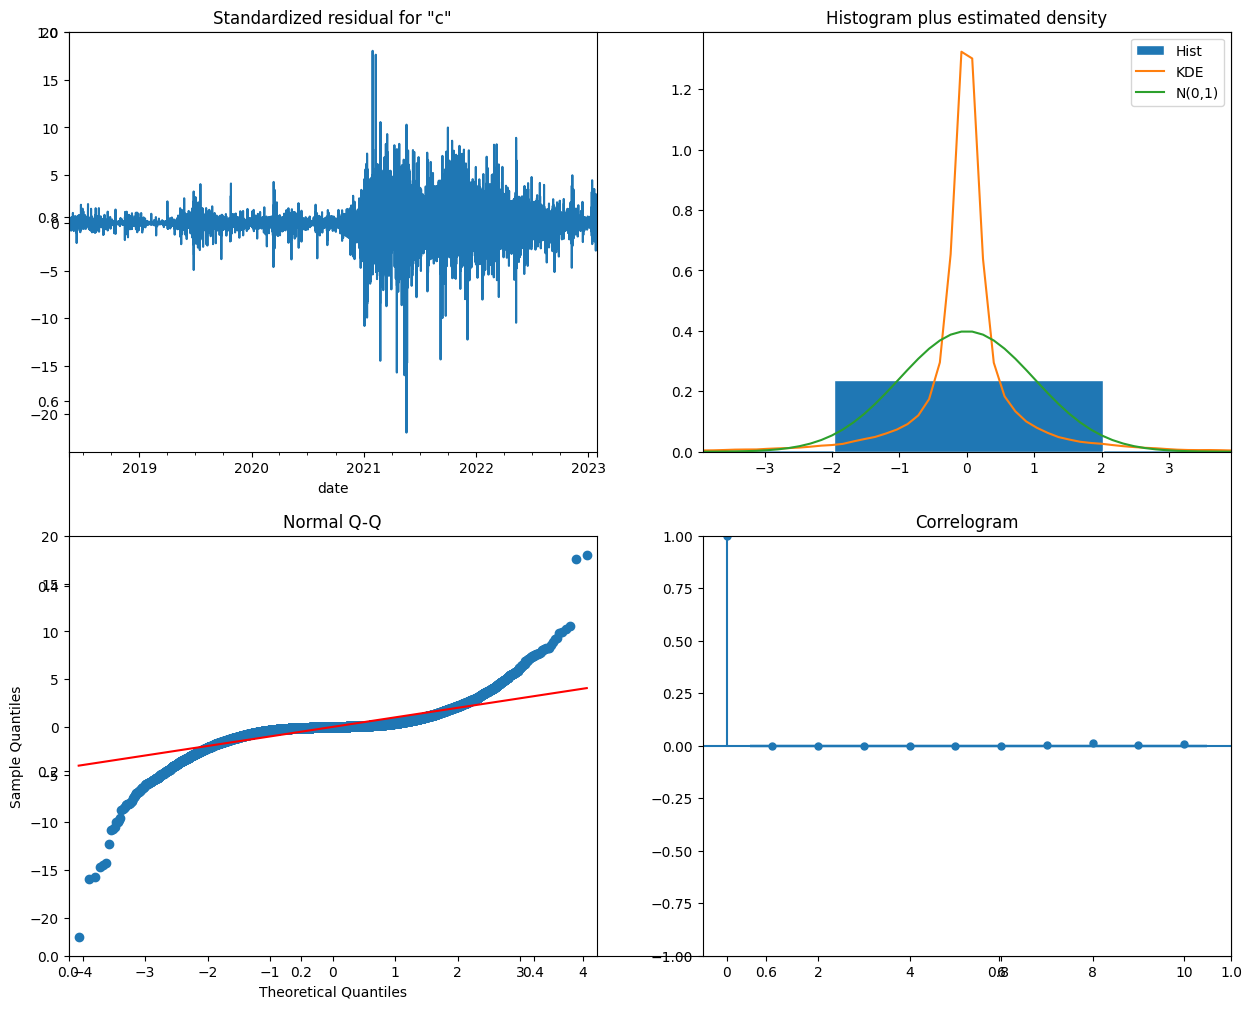

In [42]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig)
plt.show()

# Evaluate

In [107]:
model =ARIMA(y_train,order=(8,0,1)).fit()

In [108]:
y_pred_train =model.predict(y_train.index.min(),y_train.index.max())
training_mae =mean_absolute_error(y_train,y_pred_train)

In [109]:
y_pred_test =model.predict(y_test.index.min(),y_test.index.max())
test_mae =mean_absolute_error(y_test,y_pred_test)
print("Baseline MAE:", round(mae_baseline, 2))
print("Training MAE:", training_mae)
print("Test MAE:", test_mae)

Baseline MAE: 14221.02
Training MAE: 106.88674176593787
Test MAE: 317.48281934057013


In [98]:
df_pred_train = pd.DataFrame(
    {"y_train": y_train, "y_pred_train": y_pred_train},
)
df_pred_train

y_train  y_pred_train
date                                       
2018-05-15 06:00:00   8740.99  21326.403642
2018-05-15 07:00:00   8739.00   8742.089397
2018-05-15 08:00:00   8728.49   8740.105004
2018-05-15 09:00:00   8708.32   8729.666109
2018-05-15 10:00:00   8795.90   8709.712532
...                       ...           ...
2023-04-23 20:00:00  27512.00  27466.860468
2023-04-23 21:00:00  27515.00  27512.225900
2023-04-23 22:00:00  27599.00  27517.553082
2023-04-23 23:00:00  27596.00  27595.933264
2023-04-24 00:00:00  27809.00  27592.517248

[43315 rows x 2 columns]

In [99]:
fig = px.line(df_pred_train, labels={"value": "BTC"},title='Train Data')
fig.show()

In [100]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test},
)
df_pred_test

y_test        y_pred
2023-04-24 01:00:00  27768.0  27807.913266
2023-04-24 02:00:00  27740.0  27801.095630
2023-04-24 03:00:00  27781.0  27801.405290
2023-04-24 04:00:00  27704.0  27795.653273
2023-04-24 05:00:00  27657.0  27794.354981
2023-04-24 06:00:00  27549.0  27797.152248
2023-04-24 07:00:00  27449.0  27795.071133
2023-04-24 08:00:00  27181.0  27795.083298
2023-04-24 09:00:00  27306.0  27794.515768
2023-04-24 10:00:00  27414.0  27793.850259
2023-04-24 11:00:00  27540.0  27793.393822
2023-04-24 12:00:00  27441.0  27792.904612
2023-04-24 13:00:00  27629.0  27792.344003
2023-04-24 14:00:00  27432.0  27791.855588
2023-04-24 15:00:00  27266.0  27791.326811
2023-04-24 16:00:00  27116.0  27790.809259
2023-04-24 17:00:00  27381.0  27790.293971
2023-04-24 18:00:00  27337.0  27789.775602
2023-04-24 19:00:00  27380.0  27789.257806
2023-04-24 20:00:00  27453.0  27788.741145
2023-04-24 21:00:00  27414.0  27788.223272
2023-04-24 22:00:00  27468.0  27787.706149
2023-04-24 23:00:00  27512.0  27787.188871
2023-04-25 00:00:00  27499.0  27786.671606

In [101]:
fig = px.line(df_pred_test, labels={"value": "BTC"},title='Test Data')
fig.show()

In [102]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model =ARIMA(history,order=(8,0,1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

<ipython-input-102-e87ebb1c6580>:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [103]:
test_mae =mean_absolute_error(y_test,y_pred_wfv)
print("Baseline MAE:", round(mae_baseline, 2))
print("Training MAE:", training_mae)
print("Test MAE:", test_mae)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Baseline MAE: 14221.02
Training MAE: 106.88674176593787
Test MAE: 100.78623774468208
Test MAE (walk forward validation): 100.79


In [105]:
df_predictions =pd.DataFrame({'y_test':y_test,'y_pred_wfv':y_pred_wfv})
fig =px.line(df_predictions,labels={'value':'BTC'})
fig.show()